Trying to identify station locations from a game frame using a station "sprite", created by cropping the original game frame and adding a transparent background

In [12]:
import numpy as np
import skimage.io
from skimage.draw import polygon_perimeter 
from skimage.feature import match_template
from pathlib import Path
import matplotlib.pyplot as plt
from serpent.sprite import Sprite
from serpent.sprite_locator import SpriteLocator
from serpent.game_frame import GameFrame
from itertools import islice
from scipy.signal import fftconvolve

%matplotlib inline

sprite_path = '../plugins/SerpentMiniMetroGamePlugin/files/data/sprites/sprite_station_square_0.png'
frame_path = '../datasets/test/frame_1532378861.391295.png'

In [2]:
frame_img = skimage.io.imread(frame_path)
sprite_img = skimage.io.imread(sprite_path) 

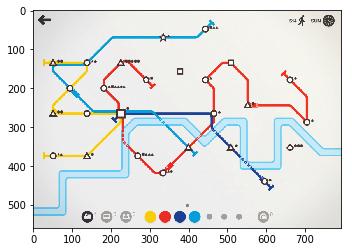

In [3]:
plt.imshow(frame_img)

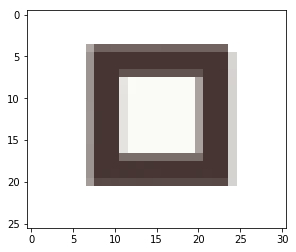

In [4]:
plt.imshow(sprite_img)

In [5]:
print('frame', frame_img.shape)
print('sprite', sprite_img.shape) # alpha channel present

frame (560, 794, 3)
sprite (26, 31, 4)


Instantiate Sprite and GameFrame instances so we can try to look for sprite in the frame

In [6]:
frame = GameFrame(frame_img)

In [7]:
sprite = Sprite("STATION_SQUARE", image_data=sprite_img[..., np.newaxis]) # require additional axis for 'animation state'

In [8]:
sprite_locator = SpriteLocator()
location = sprite_locator.locate(sprite=sprite, game_frame=frame)

location

(145, 362, 171, 393)

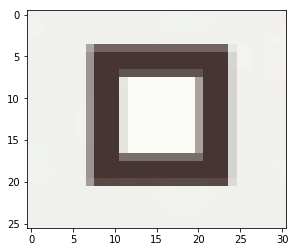

In [9]:
plt.imshow(frame_img[145:171, 362:393])

We found the sprite! 

**But how does this method work?**

First we find the `n` most common colors in the sprite (defaults to 8) and store the RGB values in a set of `signature_colors`

In [ ]:
signature_colors = sprite.signature_colors

signature_colors

What do our signature colors look like?

In [ ]:
plt.imshow(np.hstack(np.tile(np.array(rgb), (100, 100, 1)) for rgb in signature_colors[0]))

This makese sense as our sprite is nearly grayscale.

We then use the signature_colors to create a `constellation_of_pixels` which takes each of our signature colours and maps it to a single (random) pixel which matches that colour.

In [ ]:
sprite.constellation_of_pixels

Which pixels have been selected?

In [ ]:
# splitting the x, y pixels into separate lists (for numpy slicing)
pixels_y, pixels_x = list(zip(*sprite.constellation_of_pixels[0].keys()))

In [ ]:
img = sprite.image_data.copy()[...,0] # removing 'animation' channel
img[pixels_y, pixels_x] = np.array([220,20,60,255]) # converting pixels to red

plt.imshow(img)

We then select the first "constellation" pixel, looking for all exact matches of that RGB colour in the main game frame.

The other pixels in the "constellation" are then searched for relative to those matches, until we find the location of our original sprite.

#### Evaluation

Despite successfully locating our sprite this packaged method in not suitable for our purposes for two reasons:
1. It is a strict pixel match, we require something more fuzzy as Mini Metro objects are vector based (not sprites) and so there will always be subtle differences when trying to identify "other" stations
2. This method only returns the first match, we will have multiple stations requiring multiple matches